# Data Preparation

This notebook imports the raw sensor data from a csv file 'temp_humi_data.csv'. The data is pre-processed to remove outliers, impute missing values and smoothen the sensor values. The resulting time series of type pandas.Series is exported to another csv file 'time_series.csv'.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Provide path to csv file
data_file = 'data/temp_humi_data.csv'

# Read data and store in dataframe
df = pd.read_csv(data_file, header=None, 
                 names=['date','temp','humi'], 
                 parse_dates=['date'], infer_datetime_format=True, index_col='date'
                )

# Extract the data from January and February 2020
df = df.loc['2020-01-01':'2020-02-29']

# Print a summary of the data
print('Dataframe:')
print(df.describe())

Dataframe:
               temp          humi
count  86376.000000  86376.000000
mean      20.928932     65.982303
std        0.697400    112.661504
min      -10.600000      5.200000
25%       20.600000     59.900000
50%       21.000000     62.200000
75%       21.300000     64.600000
max       23.100000   3312.400000


The data contains 86k measurements of temperature (in degrees Centigrade) and humidity (in percent), taken roughly every minute with my Raspberry Pi.

The description above shows a maximum value of O(3000) for humidity. This cannot be correct and indicates a sensor failure during certain measurements. Given that both measurements `temp` and `humi` are performed by the same sensor, we suspect that whenever one measurement is compromised, the other measurement cannot be trusted either. We proceed to eliminate rows that have an outlier in either one of the two measurements.

In [3]:
# Detect and remove outliers based on z-score
df_cleaned = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print('Dataframe after removal of {} outliers:'.format(len(df)-len(df_cleaned)))
print(df_cleaned.describe())

Dataframe after removal of 508 outliers:
               temp          humi
count  85868.000000  85868.000000
mean      20.954406     62.123196
std        0.536472      4.295481
min       18.900000      5.200000
25%       20.600000     59.900000
50%       21.000000     62.200000
75%       21.300000     64.600000
max       23.000000     74.300000


Having removed outliers, we should replace them with imputed values. Besides that, it turns out that there are additional missing values. Both issues are solves by resampling the data, which were collected at minutely intervals.

In [4]:
# Resample the data on a minutely basis using a linear interpolation method
df_resampled = df_cleaned.resample('min').mean().interpolate(method='linear')
print('Dataframe after resampling:')
print(df_resampled.describe())

Dataframe after resampling:
               temp          humi
count  86400.000000  86400.000000
mean      20.945980     62.079083
std        0.551071      4.347467
min       18.900000      5.200000
25%       20.600000     59.900000
50%       21.000000     62.200000
75%       21.300000     64.600000
max       23.000000     74.300000


Let's plot the data as they are now:

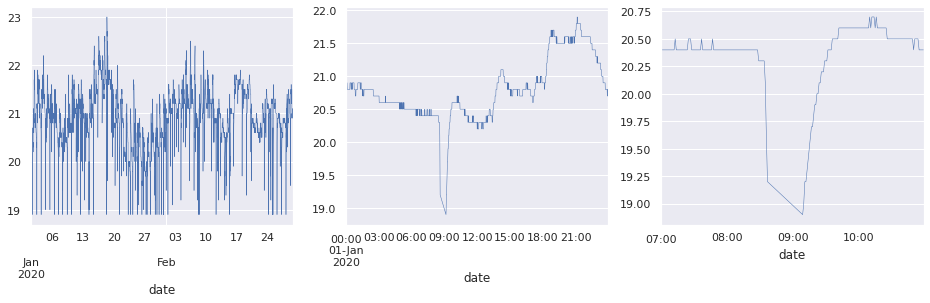

In [5]:
# Plot all temperature measurements on various time-scales (months, day, hour)
sns.set(rc={'figure.figsize':(16, 4)})
fig, axes = plt.subplots(nrows=1, ncols=3)
df_resampled['temp'].plot(ax=axes[0], linewidth=0.5);
df_resampled['temp'].loc['2020-01-01'].plot(ax=axes[1], linewidth=0.5);
df_resampled['temp'].loc['2020-01-01 07':'2020-01-01 10'].plot(ax=axes[2], linewidth=0.5);

The left-most plot shows an roughly constant average temperature between January and February. Given data over a longer period of time, we would have to include seasonality (in the natural sense of the word). In this small dataset, however, we can disregard this aspect.

The middle plot illustrates a sharp drop in temperature on a short time scale. Typically due to opening and closing of windows in the morning. It will be interesting to model these effects.

From the right-most plot we note that the sensor has an resolution of 0.1 degree Centigrade. As a result, subsequent measurements regularly oscillate between two neighboring sensor values. We do not want those jumps to be modelled by our forecaster. We solve this by smoothening the data with a rolling mean.

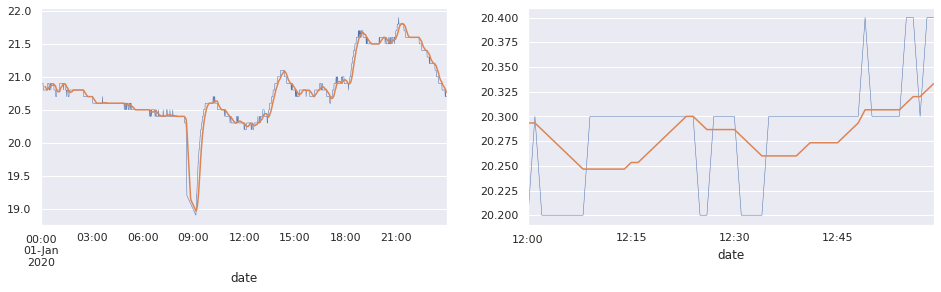

In [6]:
# Window size (in minutes)
window_size = 15

# Compute rolling mean over the window size
df_smooth = df_resampled.rolling(window_size).mean()

# Drop the first `window_size` values (NaN)
df_smooth = df_smooth.dropna()

# Plot the smooth temp measurements
sns.set(rc={'figure.figsize':(16, 4)})
fig, axes = plt.subplots(nrows=1, ncols=2)
df_resampled['temp'].loc['2020-01-01'].plot(ax=axes[0], linewidth=0.5);
df_resampled['temp'].loc['2020-01-01 12'].plot(ax=axes[1], linewidth=0.5);
df_smooth['temp'].loc['2020-01-01'].plot(ax=axes[0]);
df_smooth['temp'].loc['2020-01-01 12'].plot(ax=axes[1]);

The rolling window of 15 minutes is an acceptable compromise between, on the one hand, smoothening out local fluctuations and, on the other hand, following the behaviour of the data at larger jumps in temperature.

In the following we will focus on the time series for the temperature.

date
2020-01-01 00:14:00    20.853333
2020-01-01 00:15:00    20.846667
2020-01-01 00:16:00    20.840000
2020-01-01 00:17:00    20.833333
2020-01-01 00:18:00    20.826667
                         ...    
2020-02-29 23:55:00    20.953333
2020-02-29 23:56:00    20.946667
2020-02-29 23:57:00    20.940000
2020-02-29 23:58:00    20.933333
2020-02-29 23:59:00    20.926667
Freq: T, Name: temp, Length: 86386, dtype: float64


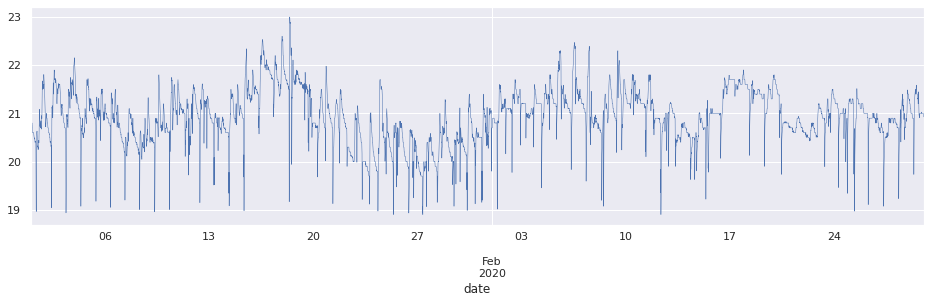

In [7]:
# In the following we focus on the time series for the temperature
time_series = df_smooth['temp']
print(time_series)
time_series.plot(linewidth=0.5);

The time series is stored in a csv file, for convenient importing into the model-building notebooks.

In [8]:
# Store pre-processed time series in csv file
time_series.to_csv('data/time_series.csv')

# which can be loaded with
# time_series = pd.read_csv('data/time_series.csv', index_col='date').asfreq('T')['temp']